# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.dummy import DummyClassifier

from tqdm import tqdm

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [6]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [7]:
data = data.astype({ "calls": "int64", "messages": "int64"})

<div style="border:solid skyblue 4px; padding: 20px">
    
- Предобработка данных не требуется.
- Звонки и сообщения приведены к целочисленному типу.

## Разбейте данные на выборки

<div style="border:solid skyblue 4px; padding: 20px">

Данные нужно разбить на три части: обучающую, валидационную и тестовую. Размеры тестового и валидационного наборов обычно равны. Исходные данные разбивают в соотношении 3:1:1. (60 20 20)

In [8]:
data_train, data_other = train_test_split(data, test_size=0.4, random_state=12345, stratify = data['is_ultra'])
print(data_train.shape)
data_other.shape

(1928, 5)


(1286, 5)

In [9]:
data_valid, data_test = train_test_split(data_other, test_size=0.5, random_state=12345, stratify = data_other['is_ultra'])

In [10]:
print(data_valid.shape)
data_test.shape

(643, 5)


(643, 5)

## Исследуйте модели

In [11]:
features_train = data_train.drop(['is_ultra'], axis=1)
target_train = data_train['is_ultra']
features_valid = data_valid.drop(['is_ultra'], axis=1)
target_valid = data_valid['is_ultra']

### Изменение гиперпараметров рещающего дерева.

<div style="border:solid skyblue 4px; padding: 20px">

Для начала посмотрим на изменение гиперпараметра максимальной глубины.

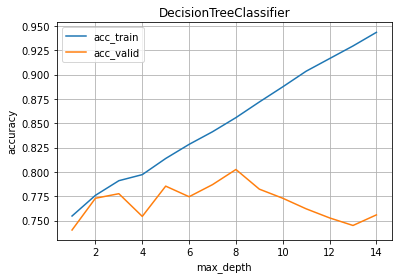

In [12]:
chart = pd.DataFrame(columns=['max_depth','acc_train','acc_valid'])


for depth in range(1,15):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth)        
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    acc_train = model.score(features_train, target_train)
    acc_valid = accuracy_score(target_valid, predictions)
    chart = chart.append({'max_depth' : depth, 'acc_train' : acc_train, 'acc_valid' : acc_valid}, ignore_index=True)

chart.plot( x='max_depth', y=['acc_train','acc_valid'], grid=True, ylabel='accuracy', title='DecisionTreeClassifier')
plt.show()


 <div style="border:solid skyblue 4px; padding: 20px">
    
Наилучший результат со значением 8. Посмотрим на гиперпараметр `splitter` (по умолчанию = "best").

In [13]:
model = DecisionTreeClassifier(max_depth=8, splitter = 'random')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
print(result)

0.7978227060653188


<div style="border:solid skyblue 4px; padding: 20px">

Результат стал хуже. Оставим по умолчанию "лучший". Добавим элемент псевдослучайности.

<div style="border:solid skyblue 4px; padding: 20px">

**Промежуточный вывод**

Лучшие значения гиперпараметров для решающего дерева(`accuracy = 0.8`):
    
- `max_depth` - 8.   
    
- `splitter` - 'best'(по умолчанию).

### Изменение гиперпараметров случайного леса.

<div style="border:solid skyblue 4px; padding: 20px">
    
Рассмотрим смену гиперпараметра `количество деревьев` и `глубину леса`.

In [14]:
best_model = None
best_result = 0
for est in tqdm(range(100, 120)):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        if result > best_result:
            best_model = model 
            best_result = result
            est_best = est
            depth_best = depth

print(f'Accuracy наилучшей модели на валидационной выборке:\
{best_result}, при n_estimators: {est_best}, max_depth: {depth_best}')

100%|██████████| 20/20 [00:43<00:00,  2.17s/it]

Accuracy наилучшей модели на валидационной выборке:0.8164852255054432, при n_estimators: 105, max_depth: 8


<div style="border:solid skyblue 4px; padding: 20px">
    
Лес из 105 деревьев при глубине 8 показал лучший результат. 

<div style="border:solid skyblue 4px; padding: 20px">

**Промежуточный вывод**

Лучшие значения гиперпараметров для случайного дерева(`accuracy = 0.816`):
    
- `max_depth` - 8.
    
- `n_estimators` - 105.

### Изменение гиперпараметров логистической регрессии.

<div style="border:solid skyblue 4px; padding: 20px">
    
Посмотрим, как влияет количество итераций.

In [15]:
max_iter_list = [100, 500, 1000, 10000]
for i in max_iter_list:
    model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=i)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    print(f'accuracy = {result}, max_iter = {i}')

accuracy = 0.7387247278382582, max_iter = 100
accuracy = 0.7387247278382582, max_iter = 500
accuracy = 0.7387247278382582, max_iter = 1000
accuracy = 0.7387247278382582, max_iter = 10000


<div style="border:solid skyblue 4px; padding: 20px">
Влияния количества итерация в данном случае нет. Изменим гиперпараметр `solver` на liblinear, так как на небольшом объеме данных он должен лучше подойти.

In [16]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
print(result)

0.71850699844479


<div style="border:solid skyblue 4px; padding: 20px">

Результат стал лучше. Посмотрим, что изменится, если убрать псевдослучайность.

In [17]:
model = LogisticRegression(solver='liblinear', max_iter= 100)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
print(result)

0.71850699844479


<div style="border:solid skyblue 4px; padding: 20px">

Результат не изменился.

<div style="border:solid skyblue 4px; padding: 20px">

**Промежуточный вывод**

Лучшие значения гиперпараметров для логистической регрессии(`accuracy = 0.757`):
    
- `solver` - `liblinear`.
    
    
Влияние количества итераций и псевдослучайности не обнаружено.

### Вывод.

<div style="border:solid skyblue 4px; padding: 20px">

Самое высокое `accuracy` получилось у случайного леса с гиперпараметрами:

- `max_depth` - 8.
    
- `n_estimators` - 105.

## Проверьте модель на тестовой выборке

In [18]:
features_test = data_test.drop(['is_ultra'], axis=1)
target_test = data_test['is_ultra']

model = RandomForestClassifier(max_depth=8, n_estimators = 105, random_state = 12345)
model.fit(features_train, target_train)
predictions = model.predict(features_test)
accuracy = accuracy_score(target_test, predictions)

accuracy

0.8102643856920684

## (бонус) Проверьте модели на адекватность

In [20]:
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(features_train, target_train)
DummyClassifier(strategy='most_frequent')
dummy_clf.predict(features_train)
score = dummy_clf.score(features_test, target_test)
score

0.6936236391912908

Заключение по проекту:

Предобработка данных:

Данные о звонках и сообщениях были приведены к целочисленному типу.
Данные были разделены на три части: обучающую, валидационную и тестовую, с обычным соотношением 60-20-20.
Исследование моделей:

Гиперпараметры модели дерева решений были настроены, достигнута точность 0,8 с следующими лучшими значениями:
max_depth: 8
splitter: 'best' (по умолчанию).

Гиперпараметры модели случайного леса были оптимизированы, достигнута точность 0,816 с следующими лучшими значениями:
max_depth: 8
n_estimators: 105.

Гиперпараметры модели логистической регрессии были настроены, и достигнута точность 0,757 с следующими лучшими значениями:
solver: 'liblinear'. Влияние количества итераций и псевдослучайности оказалось незначительным.

Самая высокая точность была достигнута с использованием модели случайного леса с определенными гиперпараметрами:

max_depth: 8

n_estimators: 105.

Модель была протестирована на тестовом наборе данных, дав точность 0,8.

Для сравнения, простая базовая модель показала точность 0,6.

В итоге, модель случайного леса с определенными гиперпараметрами оказалась наиболее точной в предсказании целевой переменной, превзойдя другие модели. Проект успешно исследовал различные алгоритмы машинного обучения и определил наилучшую модель для данной задачи.